In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import xgboost as xgb
import optuna
from catboost import CatBoostClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
RANDOM_STATE = 21
torch.manual_seed(21)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

C:\Users\lambe\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

# Data Collection

Considering that music preferences have changed over the years, I assumed that the decade in which the song was released was a sign worthy of attention

In [2]:
df_60 = pd.read_csv("data/dataset-of-60s.csv")
df_60['decade_of_release'] = '60'
df_70 = pd.read_csv("data/dataset-of-70s.csv")
df_70['decade_of_release'] = '70'
df_80 = pd.read_csv("data/dataset-of-80s.csv")
df_80['decade_of_release'] = '80'
df_90 = pd.read_csv("data/dataset-of-90s.csv")
df_90['decade_of_release'] = '90'
df_00 = pd.read_csv("data/dataset-of-00s.csv")
df_00['decade_of_release'] = '00'
df_10 = pd.read_csv("data/dataset-of-10s.csv")
df_10['decade_of_release'] = '10'
df = pd.concat([df_00, df_10, df_60, df_70, df_80, df_90])
df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,decade_of_release
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1,00
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1,00
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0,00
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0,00
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1,00


# Preprocessing

Finding the number of rows and columns

In [3]:
df.shape

(41106, 20)

Exploring data types and checking for nulls

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41106 entries, 0 to 5519
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track              41106 non-null  object 
 1   artist             41106 non-null  object 
 2   uri                41106 non-null  object 
 3   danceability       41106 non-null  float64
 4   energy             41106 non-null  float64
 5   key                41106 non-null  int64  
 6   loudness           41106 non-null  float64
 7   mode               41106 non-null  int64  
 8   speechiness        41106 non-null  float64
 9   acousticness       41106 non-null  float64
 10  instrumentalness   41106 non-null  float64
 11  liveness           41106 non-null  float64
 12  valence            41106 non-null  float64
 13  tempo              41106 non-null  float64
 14  duration_ms        41106 non-null  int64  
 15  time_signature     41106 non-null  int64  
 16  chorus_hit         41106 non

Checking for nulls again. Making doubly sure

In [5]:
df.isnull().sum()

track                0
artist               0
uri                  0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
chorus_hit           0
sections             0
target               0
decade_of_release    0
dtype: int64

We can see that there are no null values in the dataset. Taking the rough statistics of the data.

In [6]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599792,8.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


In [7]:
df['time_signature'].describe()

count    41106.000000
mean         3.893689
std          0.423073
min          0.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64

In [8]:
df = df.drop(axis=1, labels='time_signature')

Dropping the column time signature as most values are 4.


In [9]:
#Scaling the data
scale = StandardScaler()

df_X = df.iloc[:,3:17]


df_scaled = scale.fit_transform(df_X)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_X.columns
df_scaled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,chorus_hit,sections
0,0.215416,-0.429668,-0.343315,0.555679,0.665030,-0.511673,0.011220,-0.508740,-0.245926,-0.039055,0.471597,-0.320853,-0.485415,0.518152
1,0.924004,1.086412,1.354030,0.893245,-1.503691,1.277886,-1.020031,-0.508740,-0.309525,0.544503,-0.905554,0.064804,0.073928,-0.097638
2,-2.124046,1.015160,1.071139,1.357892,0.665030,-0.297994,-1.074290,-0.493684,-0.159199,-0.906910,-1.112575,0.874330,1.327148,0.518152
3,-1.977830,1.640592,-0.343315,1.219326,0.665030,1.080465,-1.074596,-0.250443,-0.055127,-0.783465,1.000112,0.174751,0.972847,-0.302901
4,0.507849,0.730153,-0.909096,1.104859,0.665030,-0.527931,-0.003533,-0.508740,-0.442506,0.331280,-0.248819,-0.345625,-0.919860,-0.097638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41101,-0.808099,0.852864,1.071139,0.781602,-1.503691,1.870147,-1.071880,-0.508052,-0.112945,0.821319,1.154862,-1.284154,-0.513802,-0.918691
41102,0.457236,0.298684,1.071139,0.741877,-1.503691,-0.488447,-0.925315,-0.488116,-0.623476,0.551984,0.509605,-0.195220,-0.274186,-0.097638
41103,0.125437,-1.051141,1.354030,-0.939738,-1.503691,-0.501221,0.223667,-0.508704,-0.552360,0.106835,1.632688,-0.378684,-0.999112,-0.097638
41104,0.462860,0.797446,0.505358,0.779719,0.665030,-0.419930,-1.074320,1.978688,1.049193,-1.228615,0.024494,0.800023,0.369873,0.107625


Managing outliers and creating boxplots to analyze the distribution of data and remove outliers

Text(0.5, 1.0, 'Distribution of predictors with outliers')

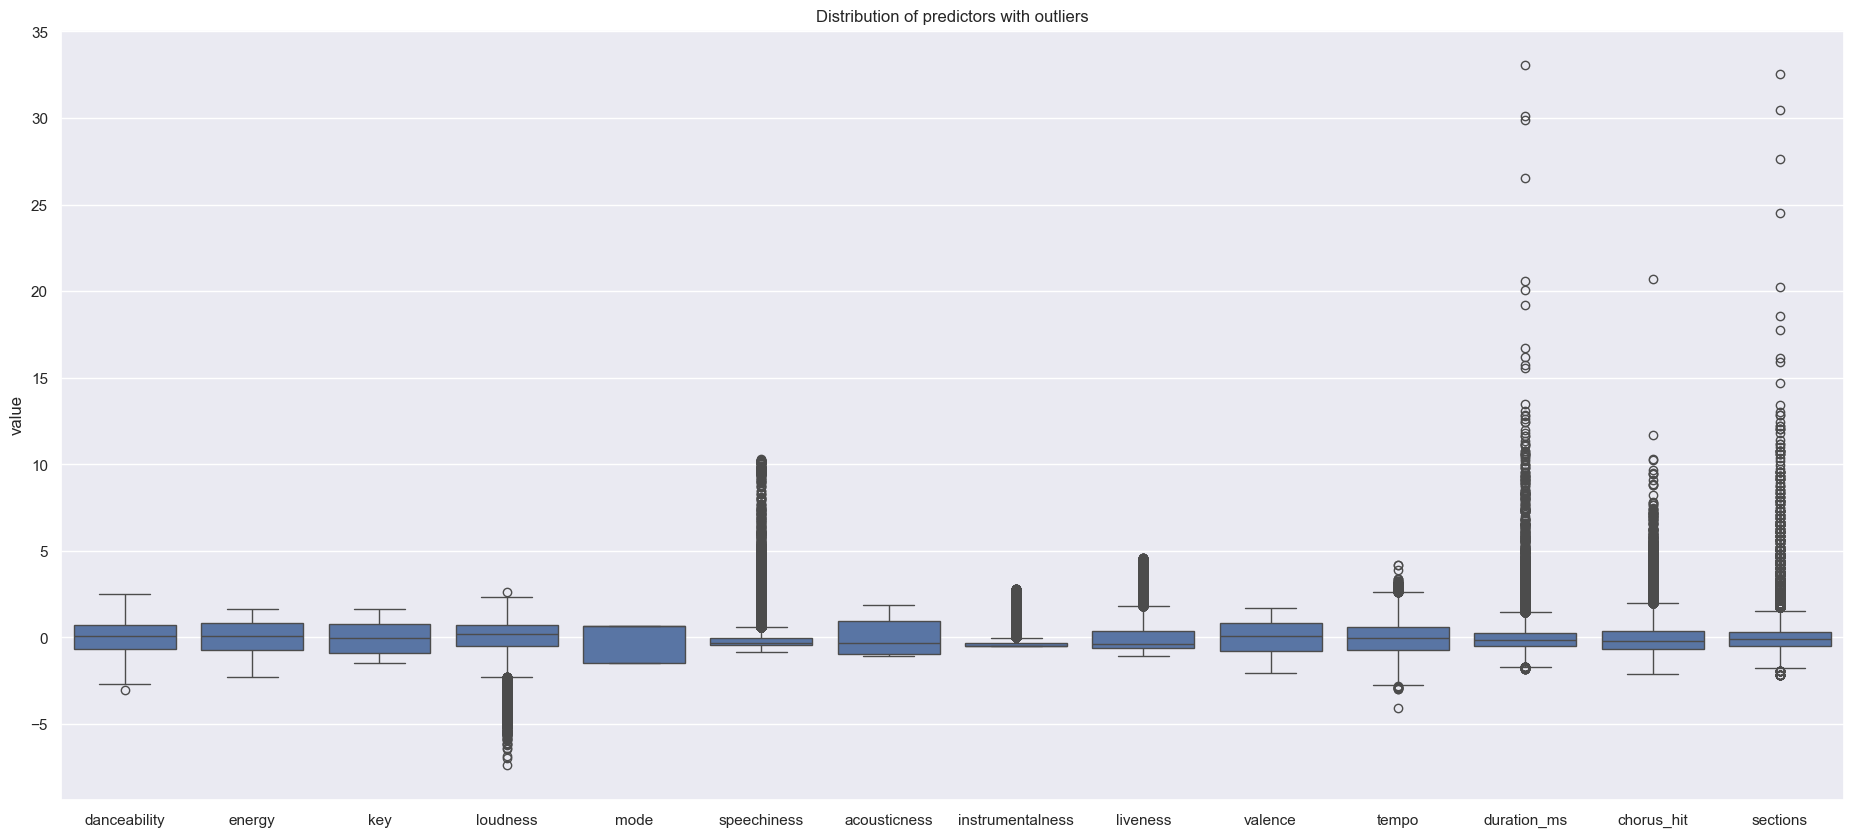

In [10]:
#box plot with outliers
df_melt=pd.melt(df_scaled)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt)
plt.xlabel(None)
plt.title('Distribution of predictors with outliers')

Text(0.5, 1.0, 'Distribution of predictors without outliers')

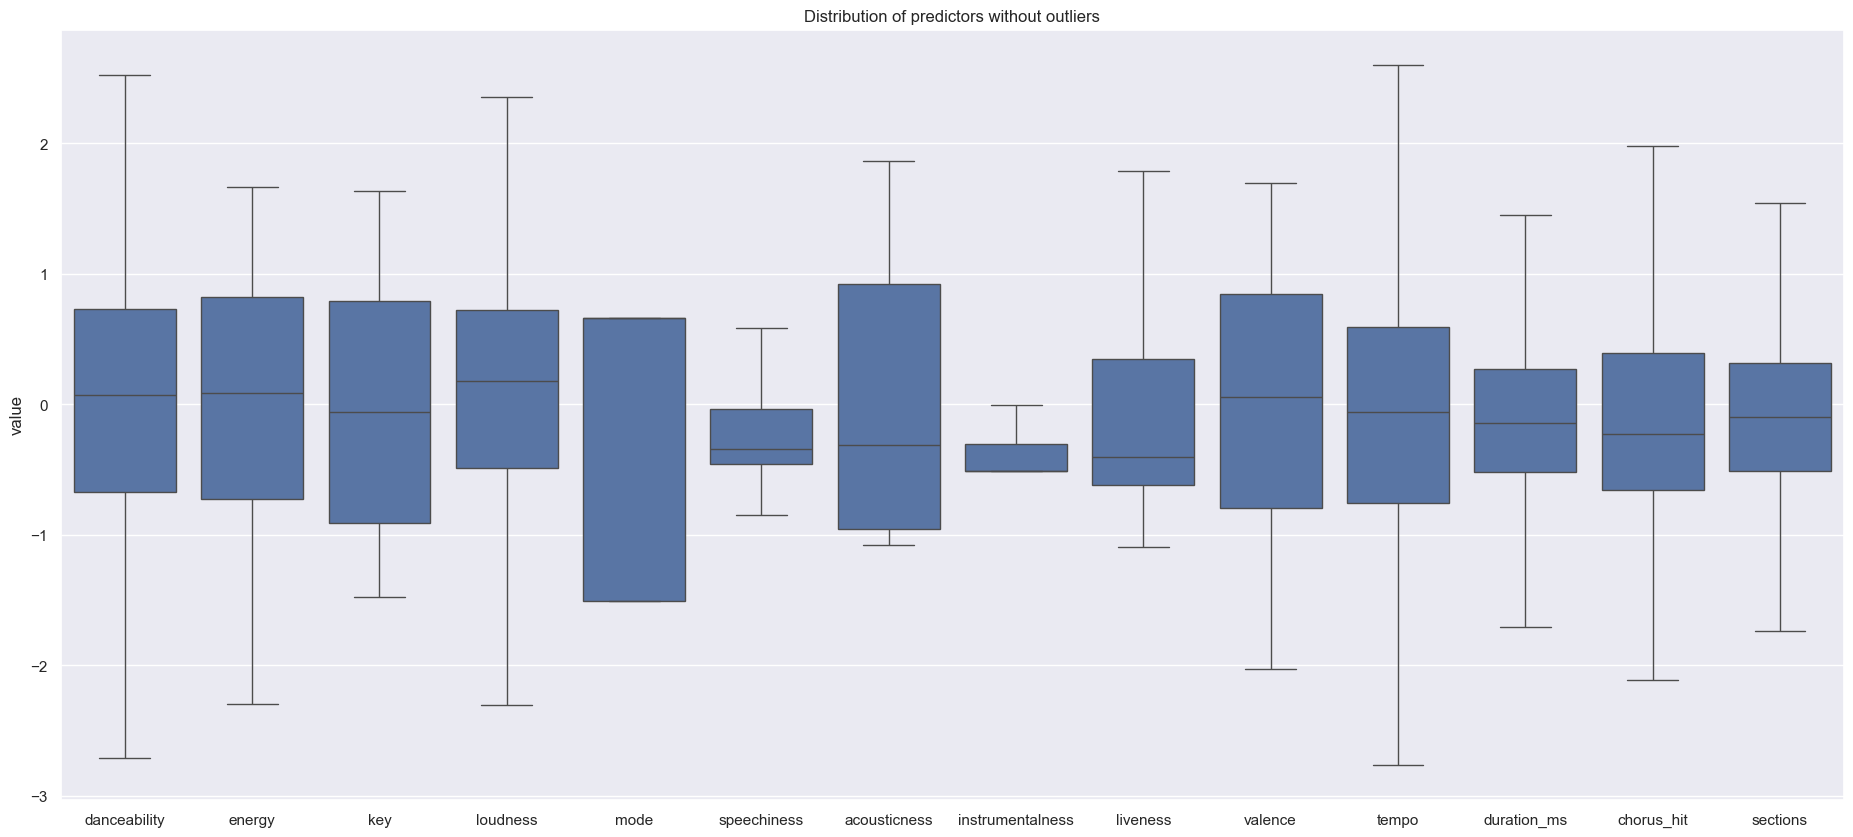

In [11]:
#boxplot without outliers
df_melt=pd.melt(df_scaled)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.xlabel(None)
plt.title('Distribution of predictors without outliers')

Removing the outliers

In [12]:
df_clean = df_scaled
for col in df_clean.columns:
  q1=df_clean[col].quantile(0.25)
  q3=df_clean[col].quantile(0.75)
  inq=q3-q1
  filter=(df_clean[col] >= q1-1.5*inq) & (df_clean[col] <= q3+1.5*inq)
  df_clean[col] = df_clean[col].loc[filter]

In [13]:
#number of outliers for each predictor
df_clean.isna().sum()

danceability           1
energy                 0
key                    0
loudness            1343
mode                   0
speechiness         5088
acousticness           0
instrumentalness    8920
liveness            2688
valence                0
tempo                434
duration_ms         1987
chorus_hit          1839
sections            1570
dtype: int64

Removing 2 predictors with a lot of outliers

In [14]:
#removing 2 predictors
df_clean = df_clean.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [15]:
df_remove = df_clean.dropna()
df_remove.shape

(33401, 12)

Total of 33401 songs remain after cleaning

Text(0.5, 1.0, 'Distribution of predictors without outliers')

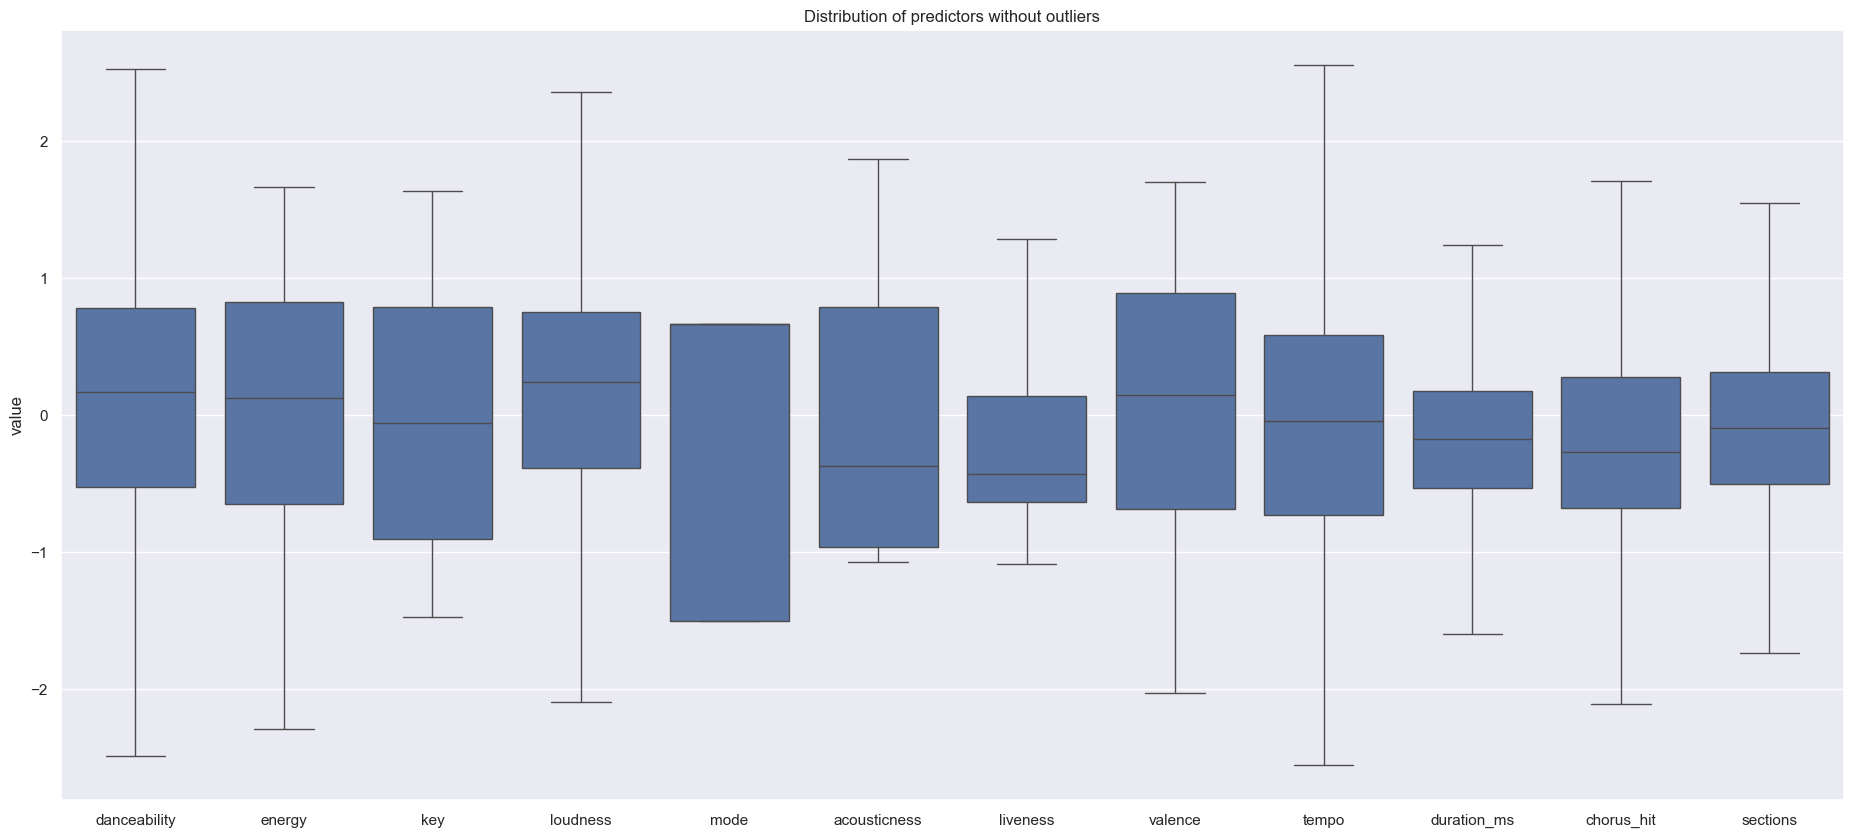

In [16]:
#box plot after removing the outliers
df_melt=pd.melt(df_remove)
df_melt
sns.set_theme(rc={'figure.figsize':(23,10)})
sns.boxplot(x='variable', y='value', data=df_melt, showfliers=False)
plt.xlabel(None)
plt.title('Distribution of predictors without outliers')

Creating the unscaled dataframe without the outliers

In [17]:
df_merge = df.iloc[df_remove.index]

In [18]:
df_merge = df_merge.drop(axis=1, labels=['speechiness', 'instrumentalness'])

In [19]:
df_merge.columns

Index(['track', 'artist', 'uri', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections', 'target', 'decade_of_release'],
      dtype='object')

Counting the number of observations in each class

In [20]:
#observations in each class
df_merge.groupby('target')[['danceability', 'energy', 'key', 'loudness',
       'mode', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms',
       'chorus_hit', 'sections']].count()

,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,duration_ms,chorus_hit,sections
target,,,,,,,,,,,,
0,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247,15247
1,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154,18154


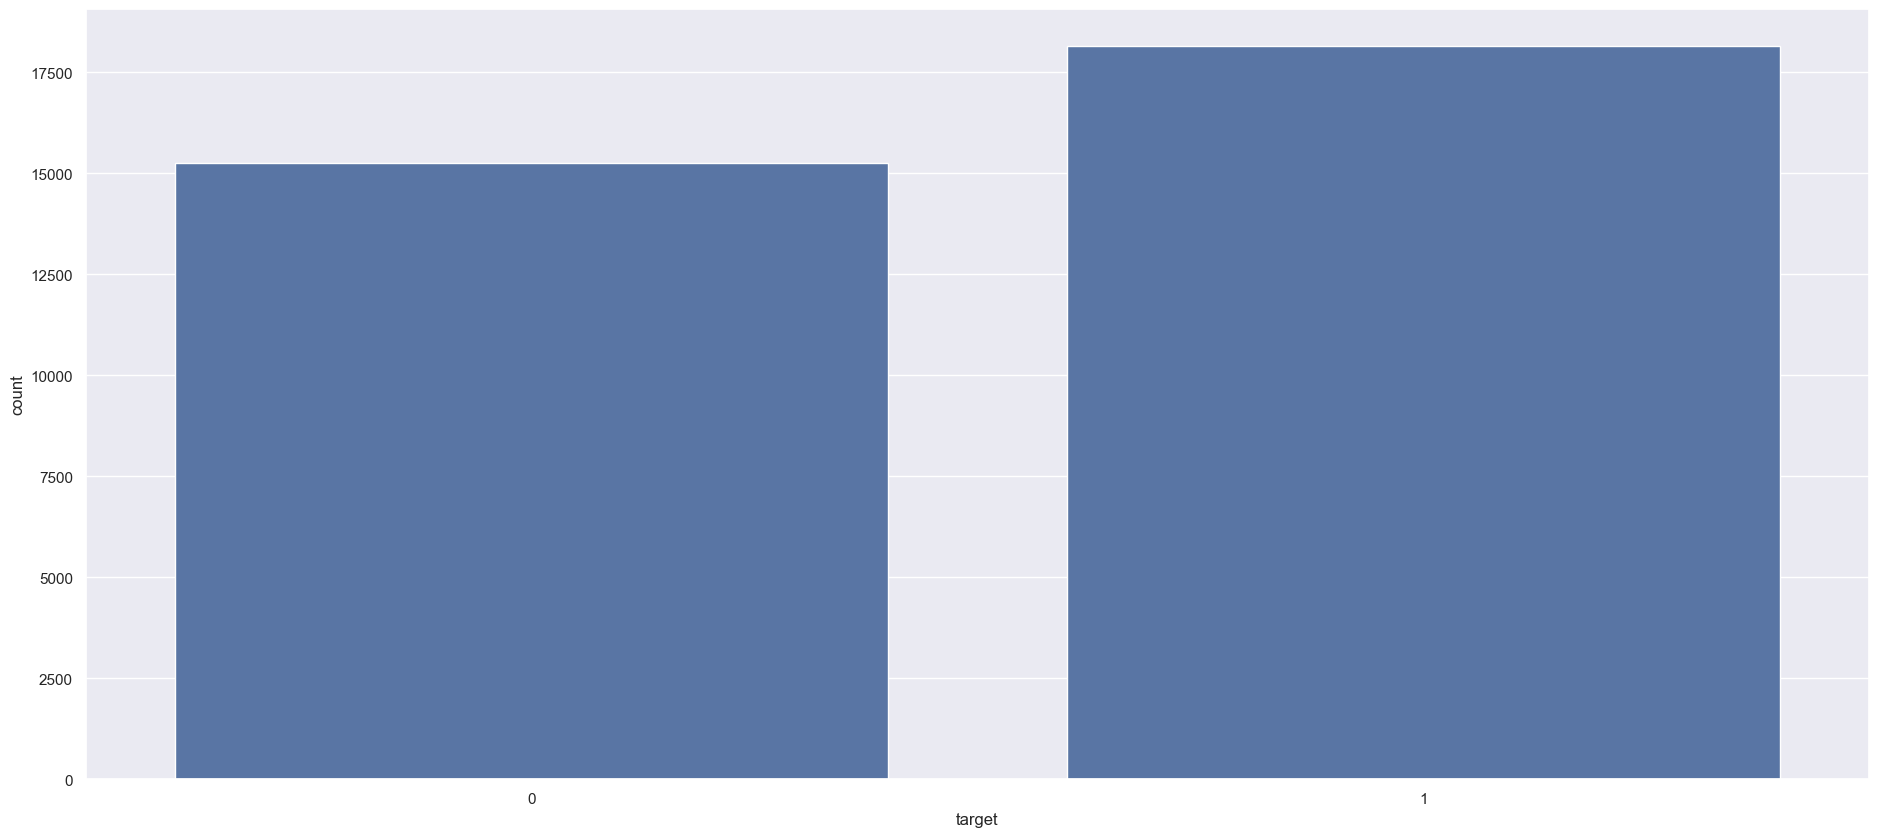

In [21]:
#plotting the number of observations
sns.countplot(x='target', data=df_merge)
sns.set_theme(rc={'figure.figsize':(12,8)})

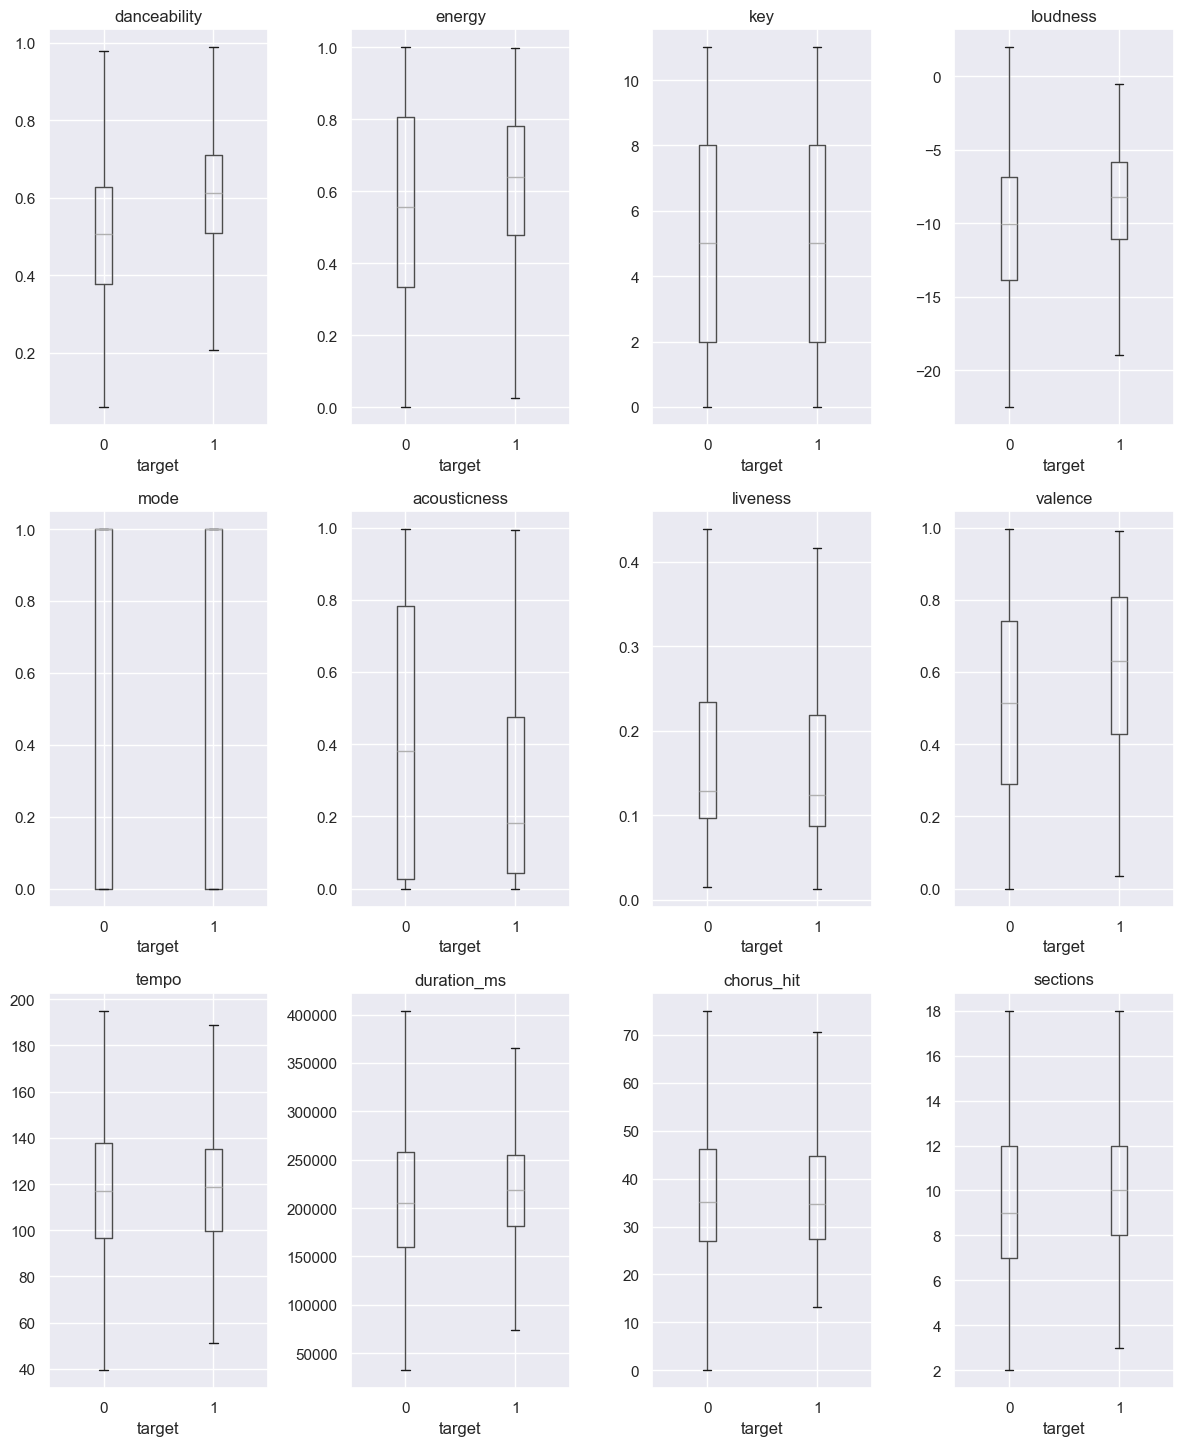

In [22]:
#plotting box plots based on target variable for different predictors
plt.rcParams["figure.figsize"] = [12, 15]
fig, axes = plt.subplots(nrows=3, ncols=4, )
df_merge.boxplot(column= 'danceability', by='target', ax=axes[0][0], showfliers=False)
df_merge.boxplot(column= 'energy', by='target', ax=axes[0][1], showfliers=False)
df_merge.boxplot(column='key', by='target', ax=axes[0][2], showfliers=False)
df_merge.boxplot(column='loudness', by='target', ax=axes[0][3], showfliers=False)
df_merge.boxplot(column='mode', by='target', ax=axes[1][0], showfliers=False)
df_merge.boxplot(column='acousticness', by='target', ax=axes[1][1], showfliers=False)
df_merge.boxplot(column='liveness', by='target', ax=axes[1][2], showfliers=False)
df_merge.boxplot(column='valence', by='target', ax=axes[1][3], showfliers=False)
df_merge.boxplot(column='tempo', by='target', ax=axes[2][0], showfliers=False)
df_merge.boxplot(column='duration_ms', by='target', ax=axes[2][1], showfliers=False)
df_merge.boxplot(column='chorus_hit', by='target', ax=axes[2][2], showfliers=False)
df_merge.boxplot(column='sections', by='target', ax=axes[2][3], showfliers=False)
plt.tight_layout()
plt.suptitle(None)
plt.show()

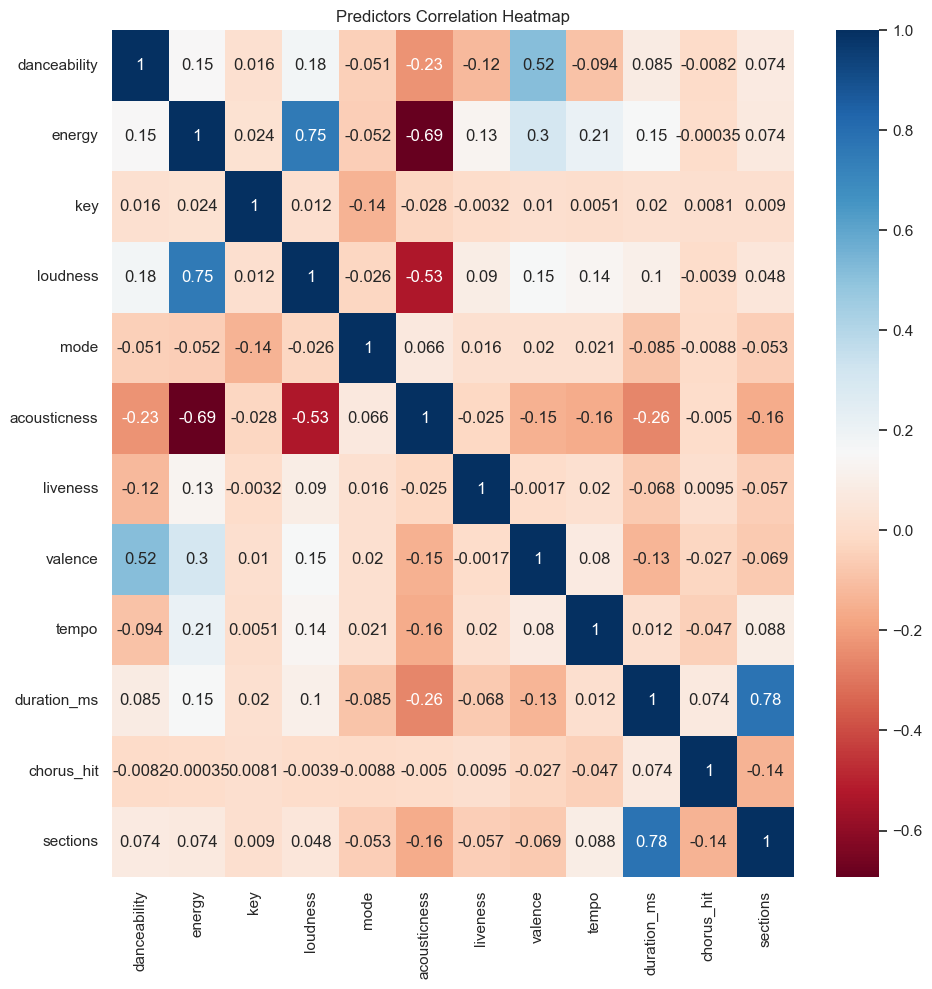

In [23]:
#correlation between the predictors
fig, ax = plt.subplots(figsize=(11,11)) 
ax = sns.heatmap(df_remove.corr(), annot=True, cmap='RdBu').set(title='Predictors Correlation Heatmap')

In [24]:
df_merge.iloc[:,3:15]

,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,duration_ms,chorus_hit,sections
0,0.578,0.471,4,-7.270,1,0.368000,0.1590,0.532,133.061,196707,30.88059,13
1,0.704,0.854,10,-5.477,0,0.018500,0.1480,0.688,92.988,242587,41.51106,10
2,0.162,0.836,9,-3.009,1,0.000111,0.1740,0.300,86.964,338893,65.32887,13
3,0.188,0.994,4,-3.745,1,0.000007,0.1920,0.333,148.440,255667,58.59528,9
4,0.630,0.764,2,-4.353,1,0.363000,0.1250,0.631,112.098,193760,22.62384,10
...,...,...,...,...,...,...,...,...,...,...,...,...
5515,0.396,0.795,9,-6.070,0,0.000928,0.1820,0.762,152.943,82107,30.34109,6
5516,0.621,0.655,9,-6.281,0,0.050600,0.0937,0.690,134.167,211653,34.89506,10
5517,0.562,0.314,10,-15.213,0,0.440000,0.1060,0.571,166.847,189827,21.11763,10
5518,0.622,0.781,7,-6.080,1,0.000101,0.3830,0.214,120.051,330053,47.13558,11


In [25]:
#creating final scaled data with all the variables
scale = StandardScaler()
scale_X = scale.fit_transform(df_merge.iloc[:,3:15])
df_merge.iloc[:,3:15] = scale_X

C:\Users\lambe\AppData\Local\Temp\ipykernel_21332\2806932618.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.33947754  1.35635314  1.0737147  ...  1.35635314  0.5084378
 -0.90475443]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_merge.iloc[:,3:15] = scale_X
C:\Users\lambe\AppData\Local\Temp\ipykernel_21332\2806932618.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.65174764 -1.5343362   0.65174764 ... -1.5343362   0.65174764
  0.65174764]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_merge.iloc[:,3:15] = scale_X
C:\Users\lambe\AppData\Local\Temp\ipykernel_21332\2806932618.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.31509384  0.40510302  1.91685711 ... -0.

In [26]:
df_merge

,track,artist,uri,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,duration_ms,chorus_hit,sections,target,decade_of_release
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.118486,-0.518795,-0.339478,0.535085,0.651748,0.072572,-0.076165,-0.126019,0.495782,-0.315094,-0.479443,1.088622,1,00
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.861614,1.100931,1.356353,0.957657,-1.534336,-0.997974,-0.181124,0.478866,-0.953376,0.405103,0.308361,0.031727,1,00
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,-2.335015,1.024808,1.073715,1.539313,0.651748,-1.054301,0.066960,-1.025591,-1.171222,1.916857,2.073455,1.088622,0,00
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,-2.181672,1.692998,-0.339478,1.365853,0.651748,-1.054618,0.238710,-0.897635,1.051932,0.610425,1.574441,-0.320571,0,00
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.425174,0.720316,-0.904754,1.222560,0.651748,0.057257,-0.400582,0.257851,-0.262302,-0.361354,-1.091335,0.031727,1,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5515,(You're A) Go Nowhere,Reagan Youth,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,-0.954921,0.851417,1.073715,0.817900,-1.534336,-1.051798,0.143293,0.765799,1.214773,-2.114016,-0.519424,-1.377467,0,90
5516,La Fiebre de Norma,La Castañeda,spotify:track:43DFcnOZprnVlAFKwgBJ3e,0.372093,0.259350,1.073715,0.768171,-1.534336,-0.899649,-0.699237,0.486621,0.535778,-0.080480,-0.181938,0.031727,0,90
5517,Good Times,Edie Brickell,spotify:track:6UPfnVoOq3y3BvapBIKs8J,0.024120,-1.182755,1.356353,-1.336912,-1.534336,0.293114,-0.581874,0.025203,1.717583,-0.423092,-1.202957,0.031727,1,90
5518,Inane,KMFDM,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,0.377991,0.792210,0.508438,0.815543,0.651748,-1.054332,2.061170,-1.359053,0.025302,1.778092,0.725184,0.384025,0,90


# Building the Model

Creating X and Y

In [27]:
X = df_merge.iloc[:,3:15]
X.shape

(33401, 12)

In [28]:
y = df_merge['target']
y.shape

(33401,)

**Step 1 for choosing the top models**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)

# First Model Training

In [30]:
#training the models
models = {
    "                   Logistic Regression": LogisticRegression(random_state=RANDOM_STATE),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Support Vector Machine (Linear Kernel)": LinearSVC(random_state=RANDOM_STATE),
    "   Support Vector Machine (RBF Kernel)": SVC(random_state=RANDOM_STATE),
    "               Neural Network(sklearn)": MLPClassifier(max_iter=500, random_state=RANDOM_STATE),
    "                         Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "            Gradient Boosting(sklearn)": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "                              Catboost": CatBoostClassifier(logging_level = 'Silent',random_state=RANDOM_STATE),
    "                               xgboost": xgb.XGBClassifier(random_state=RANDOM_STATE),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
               Neural Network(sklearn) trained.
                         Random Forest trained.
            Gradient Boosting(sklearn) trained.
                              Catboost trained.
                               xgboost trained.


In [31]:
#3-fold cross validation for choosing the top models
mean_df = []
for name, model in models.items():
  mean_arr = {}
  cv_results = cross_val_score(model, X_train, y_train, cv=3)
  mean = np.mean(cv_results)
  print(name, mean)
  mean_arr['name']=name
  mean_arr['result']=mean
  mean_df.append(mean_arr)
  
    

                   Logistic Regression 0.6815493764936985
                   K-Nearest Neighbors 0.6840570870424383
                         Decision Tree 0.6473053518154717
Support Vector Machine (Linear Kernel) 0.6822230459985276
   Support Vector Machine (RBF Kernel) 0.7342440574544726
               Neural Network(sklearn) 0.7261975017727117
                         Random Forest 0.7380613176825584
            Gradient Boosting(sklearn) 0.7309879391568335
                              Catboost 0.7442364674004563
                               xgboost 0.7308382231499749


In [32]:
pd.DataFrame(mean_df).sort_values('result',ascending=False)

,name,result
8,Catboost,0.744236
6,Random Forest,0.738061
4,Support Vector Machine (RBF Kernel),0.734244
7,Gradient Boosting(sklearn),0.730988
9,xgboost,0.730838
5,Neural Network(sklearn),0.726198
1,K-Nearest Neighbors,0.684057
3,Support Vector Machine (Linear Kernel),0.682223
0,Logistic Regression,0.681549
2,Decision Tree,0.647305


### Intermediate conclusions
1. Catboost showed the best result, it's worth continuing to work with it
2. Random forest showed a fairly good result, while remaining fast enough and leaving room for interpretation.
3. Sklearn neural network showed good result. I should try to build torch NN for this task

# **5 fold Cross Validation for choosing the best model**

Catboost

In [33]:
def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    catboost_model = CatBoostClassifier(**params, logging_level = 'Silent',random_state=RANDOM_STATE)
    catboost_model.fit(X_train, y_train)
    predictions = catboost_model.predict(X)
    score = f1_score(y, predictions)
    return score
catboost_study = optuna.create_study(direction='maximize')
catboost_study.optimize(objective, n_trials=30)
print(f'Best hyperparameters: {catboost_study.best_params}')
print(f'Best accuracy_score: {catboost_study.best_value}')

[I 2025-05-14 20:13:45,931] A new study created in memory with name: no-name-2bee7ff6-70be-4348-9456-1d158b0aa668
[I 2025-05-14 20:13:55,569] Trial 0 finished with value: 0.7695948976032687 and parameters: {'learning_rate': 0.005215301828972918, 'depth': 3, 'subsample': 0.8871185355690216, 'colsample_bylevel': 0.8111961468902821, 'min_data_in_leaf': 23}. Best is trial 0 with value: 0.7695948976032687.
[I 2025-05-14 20:14:03,143] Trial 1 finished with value: 0.848960477562783 and parameters: {'learning_rate': 0.04411178258555791, 'depth': 7, 'subsample': 0.7036076179243324, 'colsample_bylevel': 0.5571874774758767, 'min_data_in_leaf': 41}. Best is trial 1 with value: 0.848960477562783.
[I 2025-05-14 20:14:06,565] Trial 2 finished with value: 0.7520838532568006 and parameters: {'learning_rate': 0.0019525197331073075, 'depth': 2, 'subsample': 0.6157234878608079, 'colsample_bylevel': 0.8764756118964314, 'min_data_in_leaf': 99}. Best is trial 1 with value: 0.848960477562783.
[I 2025-05-14 20

Best hyperparameters: {'learning_rate': 0.09961620774491757, 'depth': 10, 'subsample': 0.33095973140556967, 'colsample_bylevel': 0.557602797050017, 'min_data_in_leaf': 64}
Best accuracy_score: 0.9517060939714379


Torch NN

In [42]:
# Transform data into pytorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

# Build datasets for model
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200)

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 50),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(50, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

    def predict(self, x, threshold=0.5):
        with torch.no_grad():
            probabilities = self.model(x)
            return (probabilities >= threshold).int()

# init
input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Main function
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=1000, patience=10, min_delta=0.001):
    best_test_loss = float('inf')
    best_weights = None
    patience_counter = 0

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)

        # Test
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        test_loss /= len(valid_loader.dataset)

        # Progres report
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {test_loss:.4f}')

        # Early stop check
        if test_loss < best_test_loss - min_delta:
            best_test_loss = test_loss
            best_weights = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stop on epoch {epoch+1}')
            model.load_state_dict(best_weights)
            break

    # Best weights restore
    if best_weights is not None:
        model.load_state_dict(best_weights)

    return model

# Model training
torch_model = train_model(
    model,
    train_loader,
    test_loader,
    criterion,
    optimizer,
    epochs=1000,
    patience=10,
    min_delta=0.001
)
print(f'TorchNN accuracy_score - {accuracy_score(y_test_tensor, torch_model.predict(X_test_tensor))}')

Epoch 1/1000, Train Loss: 0.5968, Valid Loss: 0.5717
Epoch 2/1000, Train Loss: 0.5594, Valid Loss: 0.5571
Epoch 3/1000, Train Loss: 0.5473, Valid Loss: 0.5510
Epoch 4/1000, Train Loss: 0.5449, Valid Loss: 0.5494
Epoch 5/1000, Train Loss: 0.5389, Valid Loss: 0.5443
Epoch 6/1000, Train Loss: 0.5376, Valid Loss: 0.5446
Epoch 7/1000, Train Loss: 0.5329, Valid Loss: 0.5401
Epoch 8/1000, Train Loss: 0.5313, Valid Loss: 0.5394
Epoch 9/1000, Train Loss: 0.5288, Valid Loss: 0.5409
Epoch 10/1000, Train Loss: 0.5265, Valid Loss: 0.5374
Epoch 11/1000, Train Loss: 0.5239, Valid Loss: 0.5359
Epoch 12/1000, Train Loss: 0.5238, Valid Loss: 0.5356
Epoch 13/1000, Train Loss: 0.5211, Valid Loss: 0.5355
Epoch 14/1000, Train Loss: 0.5201, Valid Loss: 0.5345
Epoch 15/1000, Train Loss: 0.5193, Valid Loss: 0.5337
Epoch 16/1000, Train Loss: 0.5164, Valid Loss: 0.5336
Epoch 17/1000, Train Loss: 0.5171, Valid Loss: 0.5328
Epoch 18/1000, Train Loss: 0.5149, Valid Loss: 0.5328
Epoch 19/1000, Train Loss: 0.5136, Va

**Random Forest**

In [43]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=1000, step=100),
        "max_depth": trial.suggest_int(name="max_depth", low=10, high=110, step=20),
        "min_samples_split": trial.suggest_int(name="min_samples_split", low=2, high=10, step=2),
        "min_samples_leaf": trial.suggest_int(name="min_samples_leaf", low=1, high=4, step=1)
    }
    forest_model = RandomForestClassifier(random_state=RANDOM_STATE, **params)
    forest_model.fit(X_train, y_train)
    predictions = forest_model.predict(X)
    score = f1_score(y, predictions)
    return score
forest_study = optuna.create_study(direction='maximize')
forest_study.optimize(objective, n_trials=20)
print(f'Best hyperparameters: {forest_study.best_params}')
print(f'Best accuracy_score: {forest_study.best_value}')

[I 2025-05-14 20:45:24,633] A new study created in memory with name: no-name-3929f957-2656-4c6d-bfeb-6a24694872cd
[I 2025-05-14 20:45:37,175] Trial 0 finished with value: 0.906852077915185 and parameters: {'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.906852077915185.
[I 2025-05-14 20:46:12,227] Trial 1 finished with value: 0.9347116137216269 and parameters: {'n_estimators': 500, 'max_depth': 90, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9347116137216269.
[I 2025-05-14 20:46:48,737] Trial 2 finished with value: 0.8056222146040453 and parameters: {'n_estimators': 1000, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9347116137216269.
[I 2025-05-14 20:47:14,418] Trial 3 finished with value: 0.9323636363636364 and parameters: {'n_estimators': 400, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with valu

KeyboardInterrupt: 

The accuracy for the random forest model is 0.74

We choose Random Forest as our final model.

# **Model Implementation Part 2: Random Forest Model**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)


**Importance of the variables**

In [ ]:
#feature importance
importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]
feature_importances

In [ ]:
#plotting feature importance
feat_importances_plot = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances_plot.plot(kind='barh')
plt.ylabel("Predictors")
plt.xlabel("Feature Importance")

In [ ]:
#dropping 3 less important predictors
X_reduced = X.drop(labels=['key', 'mode', 'sections'], axis=1)
X_reduced

In [ ]:
X_red_train, X_red_test, y_red_train , y_red_test = train_test_split(X_reduced, y, test_size=0.2, random_state=1)

In [ ]:
cross_val_score(RandomForestClassifier(),X_red_train, y_red_train,cv=5)

In [ ]:
np.mean([0.73409431, 0.72735778, 0.73671407, 0.73353293, 0.73484281])

The accuracy is decreased by 0.006 and the running time is reduced by 1 second, therefore we will not use this trade off in our model and we will continue to use all the features.

**PCA**

In [ ]:
from sklearn.decomposition import PCA

pca_test = PCA(n_components=12)
pca_test.fit(X_train)
sns.set(style='whitegrid')
sns.set(rc={'figure.figsize':(8,6)})

plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
display(plt.show())

We Can use 7 principle components to capture 90% of the total variance.

In [ ]:
pca = PCA(n_components=7)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
cross_val_score(RandomForestClassifier(),X_train_pca, y_train,cv=5)

In [ ]:
np.mean([0.68712575, 0.68731287, 0.67477545, 0.68787425, 0.6925524 ])

It can be seen that the performance of the model is not enhanced with dimension reduction.

Hyperparameter

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#number of trees in the model
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

#maximum number of splits for each tree
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]

#minimum number of cases required before splitting
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

#minimum number required in each leaf at the end
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]

bootstrap = [True, False]

param_dist = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

               

In [ ]:
rf_rs = RandomizedSearchCV(rf, 
                        param_dist, 
                        n_iter = 40, 
                        cv = 3, 
                        n_jobs=-1, 
                        random_state=1)
rf_rs.fit(X_train, y_train)
rf_rs.best_params_


In [ ]:
random_df = pd.DataFrame(rf_rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
random_df = random_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig.set_size_inches(18,18)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=random_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.65,.75])
axs[0,0].set_title(label = 'n_estimators', size=10, weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=random_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.65,.75])
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=random_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.65,.75])
axs[0,2].set_title(label = 'min_samples_leaf', size=10, weight='bold')


sns.barplot(x='param_max_depth', y='mean_test_score', data=random_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.65,.75])
axs[1,1].set_title(label = 'max_depth', size=10, weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=random_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.65,.75])
axs[1,2].set_title(label = 'bootstrap', size=10, weight='bold')

axs[1,0].set_axis_off()
plt.show()

From the results for the number of estimators we choose [400,900].
For min sample split we choose [2,12,28].
For min sample leaf we choose [28,34].
For max depth we choose [12,13].
And we choose bootstrap False.

In [ ]:
grid = {'bootstrap': [False],
 'max_depth': [12,13],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [28, 34],
 'min_samples_split': [2, 12, 28],
 'n_estimators': [ 400, 900]}

In [ ]:
gs = GridSearchCV(rf, grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

In [ ]:
y_pred = gs.best_estimator_.predict(X_test)
accuracy_score(y_test,y_pred)

In [ ]:
sum(y_test == 1)

# Performance Evaluation and Interpretation

Importing Accuracy score, confusion matrix and Classification report

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Calculating accuracy scores

In [ ]:
accuracy_score(y_test, y_pred)

View Confusion Matrix for test data and the predictions

In [ ]:
confusion_matrix(y_test, y_pred, labels=[1, 0])

Printing the classification report for test data and the predictions

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
y_prob= rf.predict_proba((X_test))

In [ ]:
prob_1 = y_prob[::,1]

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  prob_1)
auc = metrics.roc_auc_score(y_test, prob_1)

#create ROC curve
plt.plot(fpr,tpr, label="AUC="+str(auc))
plt.ylabel('Sensitivity')
plt.xlabel('1-Specificity')
plt.legend(loc=4)
plt.show()
